In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
BATCH_SIZE = 32

EPOCHS = 60

VALIDATION_SIZE = 16

DATA_PATH = "./annual_csv.csv"

WINDOW_SIZE = 30

In [3]:
#%% Veri yüklenir
try:
  df = pd.read_csv(DATA_PATH)
except:
  !pip install datapackage
  import datapackage
  data_url = 'https://datahub.io/core/global-temp/datapackage.json'
  # to load Data Package into storage
  package = datapackage.Package(data_url)
  # to load only tabular data
  resources = package.resources
  df = pd.read_csv(resources[1].descriptor['path'])

df.head()

,Source,Year,Mean
0,GCAG,2016,0.9363
1,GISTEMP,2016,0.9900
2,GCAG,2015,0.8998
3,GISTEMP,2015,0.8700
4,GCAG,2014,0.7408


In [4]:
#%% Veri yüklenir ve data-pipeline hazırlanır
df = df[df["Source"] == "GISTEMP"] # GISTEMP 137 X 3
df = df.sort_values(by=['Year']) # Yıla Göre Sıralar
series = df.loc[:, "Mean"].values
time = df.loc[:, "Year"].values
dataset = tf.data.Dataset.from_tensor_slices(series)

''' veri seti test ve val seti olarak ikiye bölünür'''
time_train = time[:-VALIDATION_SIZE]
x_train = series[:-VALIDATION_SIZE]
time_valid = time[-VALIDATION_SIZE:]
x_valid = series[-VALIDATION_SIZE:]

def windowed_dataset(series, window_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  shuffle_buffer = len(dataset)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size)
  return dataset

dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE)

print(dataset)

<BatchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


In [5]:
#%% ANN MODELİ

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(30 , activation="relu", input_shape=[WINDOW_SIZE]),
  tf.keras.layers.Dense(30 , activation="relu"),
  tf.keras.layers.Dense(1)
])

"""
#%% RNN MODELİ

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(30, return_sequences=True),
  tf.keras.layers.SimpleRNN(30),
  tf.keras.layers.Dense(1)
])

#%% LSTM MODELİ

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30)),
  tf.keras.layers.Dense(1)
])
"""

Wsave = model.get_weights()

optimizer = tf.keras.optimizers.Adam()

model.compile(loss="mse", optimizer=optimizer)

history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/60
3/3 [==============================] - 1s 34ms/step - loss: 0.0573
Epoch 2/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0467
Epoch 3/60
3/3 [==============================] - 0s 5ms/step - loss: 0.0385
Epoch 4/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0315
Epoch 5/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0270
Epoch 6/60
3/3 [==============================] - 0s 6ms/step - loss: 0.0228
Epoch 7/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0197
Epoch 8/60
3/3 [==============================] - 0s 5ms/step - loss: 0.0168
Epoch 9/60
3/3 [==============================] - 0s 5ms/step - loss: 0.0152
Epoch 10/60
3/3 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 11/60
3/3 [==============================] - 0s 5ms/step - loss: 0.0133
Epoch 12/60
3/3 [==============================] - 0s 6ms/step - loss: 0.0127
Epoch 13/60
3/3 [==============================] - 0s 6ms/step - loss: 0

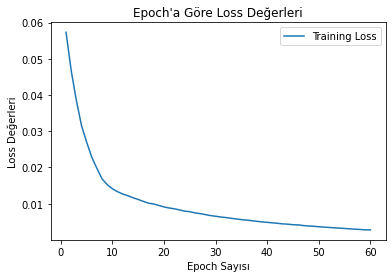

MSE:  0.002764730714261532


In [6]:
#%% Eğitim aşaması ve model sonuçları görselleştirip ve yazdırılır.

def plot_hist(lab, epochs, tr_value):
    plt.plot(epochs, tr_value, label = lab["tr_name"] )
    plt.legend()
    plt.xlabel(lab["x"])
    plt.ylabel(lab["y"])
    plt.title(lab["tit"])
    plt.show()
    
epochs = range(1,EPOCHS+1)

# plot losses
loss_lab = {"x":"Epoch Sayısı", "y":"Loss Değerleri",
           "tit":"Epoch'a Göre Loss Değerleri",
           "tr_name":"Training Loss" }
tr_losses = history.history['loss']

plot_hist(loss_lab, epochs, tr_losses)
print("MSE: ",tr_losses[-1] )


 predicting: 107/107

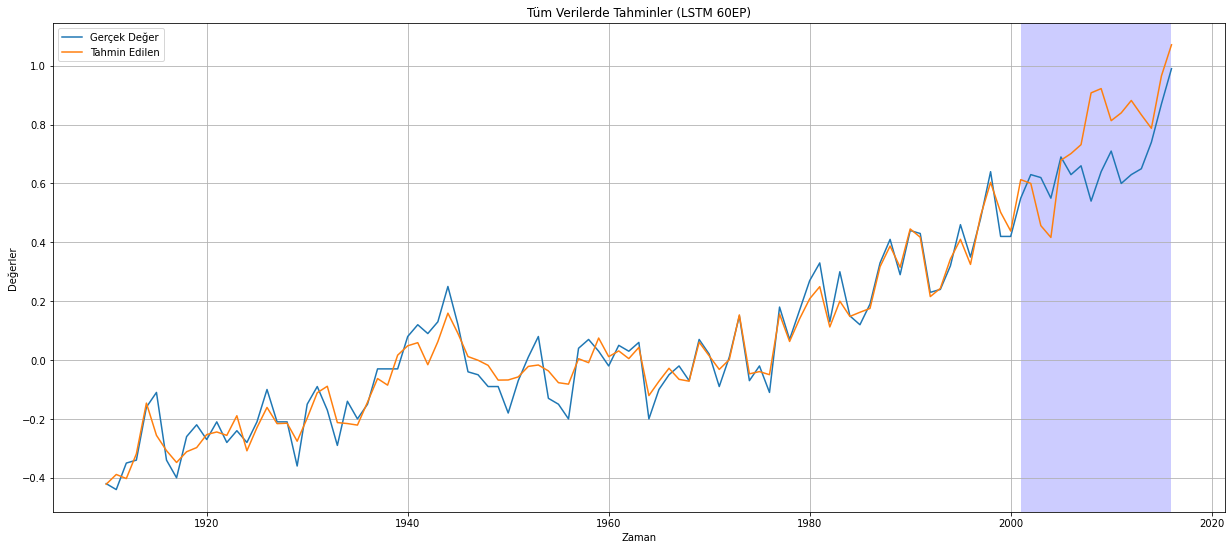

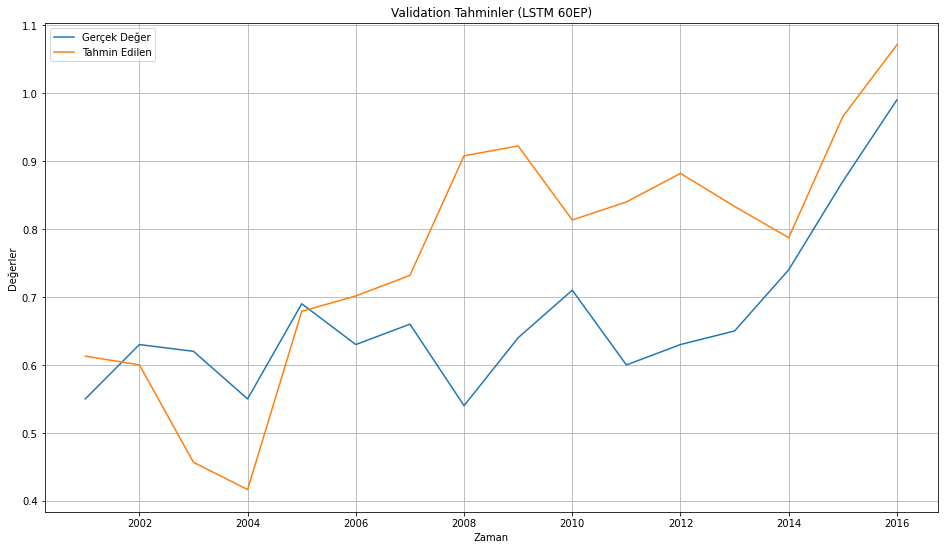

In [7]:
#%% Tahmin Grafikleri

def calculate_forcast(series, window_size, model, forcast_begin = (len(series)- VALIDATION_SIZE)):
    '''
    crates predictions from series it will produce len(series) - window size prediction
    at most
    Args:
        series (list) -- list values to predict
        window_size (int) -- size of window to making prediction from 
        little series
        model (tf.model) -- tensorflow trained model
        forcast_begin (int) -- to forecasting it impress index of which data 
        predicted first
    Returns:
        list of number which all predictions as np 1d array
    '''
    forecast = []
    if forcast_begin < window_size:
        forcast_begin = window_size
    number_series = len(series) - window_size
    for tim in range(forcast_begin - window_size, number_series):
        forecast.append(model.predict(np.expand_dims(series[tim:tim + window_size], 0)))
        sys.stdout.write(f"\r predicting: {tim+1}/{number_series}")
    return np.array(forecast)[:, 0, 0]
  
def plot_series(time, series, label, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Zaman")
    plt.ylabel("Değerler")
    plt.grid(True)
    
results = calculate_forcast(series, WINDOW_SIZE, model, forcast_begin = 0)

plt.figure(figsize=(21, 9))
plot_series(time[WINDOW_SIZE:], series[WINDOW_SIZE:], label="Gerçek Değer")
plot_series(time[WINDOW_SIZE:], results, "Tahmin Edilen")
plt.axvspan(time[-VALIDATION_SIZE], time[-1], facecolor='b', alpha=0.2)
plt.title("Tüm Verilerde Tahminler (ANN 60EP)")
plt.legend()
plt.show()

plt.figure(figsize=(16, 9))
plot_series(time_valid, x_valid, label="Gerçek Değer")
plot_series(time_valid, results[(len(series)- VALIDATION_SIZE)-WINDOW_SIZE:], "Tahmin Edilen")
plt.title("Validation Tahminler (ANN 60EP)")
plt.legend()
plt.show()

Epoch 1/60
4/4 [==============================] - 0s 4ms/step - loss: 0.1199
Epoch 2/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0604
Epoch 3/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0247
Epoch 4/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0234
Epoch 5/60
4/4 [==============================] - 0s 6ms/step - loss: 0.0221
Epoch 6/60
4/4 [==============================] - 0s 2ms/step - loss: 0.0157
Epoch 7/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 8/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 9/60
4/4 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 10/60
4/4 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 11/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 12/60
4/4 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 13/60
4/4 [==============================] - 0s 5ms/step - loss: 0.

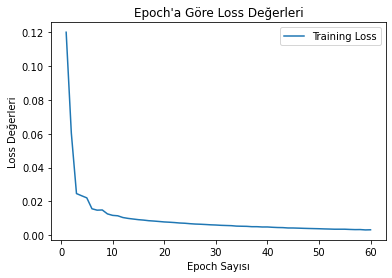

 predicting: 107/107

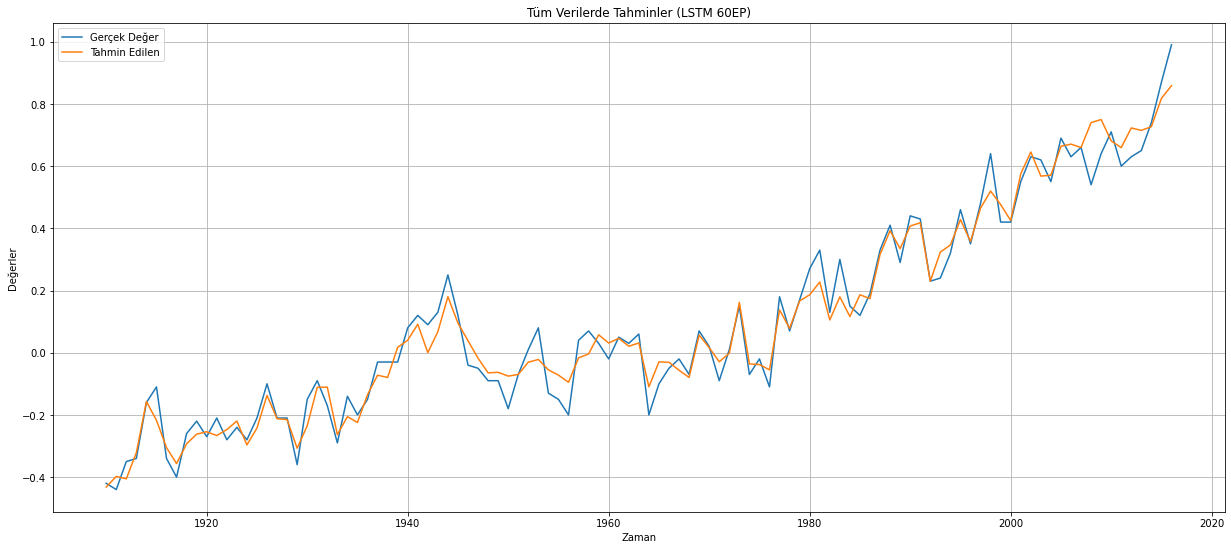

MSE:  0.0032701590098440647


In [8]:
#%% Tüm sette eğitim

model.set_weights(Wsave)
fll_dataset = windowed_dataset(series, WINDOW_SIZE, BATCH_SIZE)
history = model.fit(fll_dataset, epochs=EPOCHS)

loss_lab = {"x":"Epoch Sayısı", "y":"Loss Değerleri",
           "tit":"Epoch'a Göre Loss Değerleri",
           "tr_name":"Training Loss" }
tr_losses = history.history['loss']
plot_hist(loss_lab, epochs, tr_losses)

results = calculate_forcast(series, WINDOW_SIZE, model, forcast_begin = 0)
plt.figure(figsize=(21, 9))
plot_series(time[WINDOW_SIZE:], series[WINDOW_SIZE:], label="Gerçek Değer")
plot_series(time[WINDOW_SIZE:], results, "Tahmin Edilen")
plt.title("Tüm Verilerde Tahminler (ANN 60EP)")
plt.legend()
plt.show()

print("MSE: ",tr_losses[-1] )

model.save("global_warm_TS.h5")

       Yıl  Tahminler
0   2017.0   0.856787
1   2018.0   0.930540
2   2019.0   0.914398
3   2020.0   0.921239
4   2021.0   0.963282
5   2022.0   1.007040
6   2023.0   1.004703
7   2024.0   0.990999
8   2025.0   1.083478
9   2026.0   1.111901
10  2027.0   1.111954
11  2028.0   1.092169
12  2029.0   1.094988
13  2030.0   1.179211


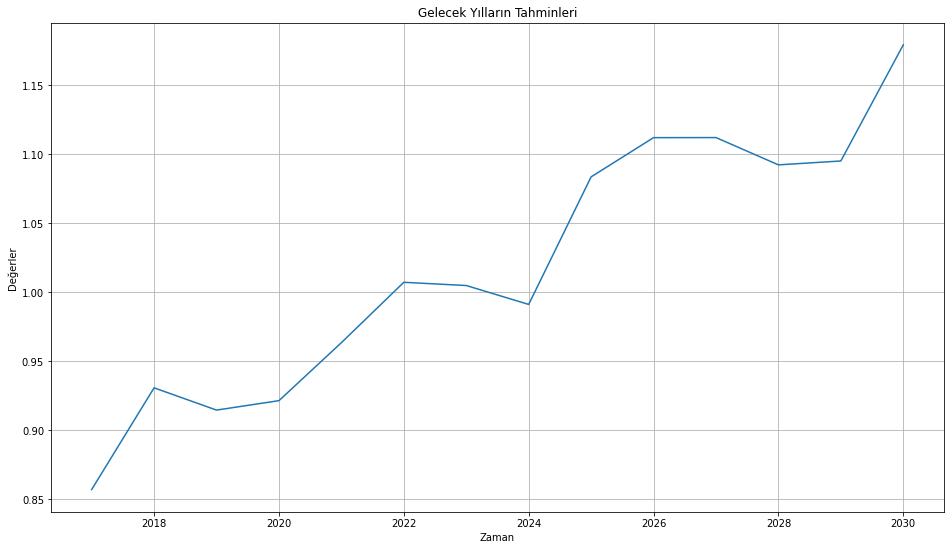

In [9]:
#%% Sonraki yılları tahmin etme

years = 14
last_year = 2016

forecast = series[-WINDOW_SIZE:].tolist()
for i in range(years):
    prediction = model.predict(np.array([forecast[-WINDOW_SIZE:]]))
    forecast.append(float(prediction))
forecast = forecast[-years:]
time_fu = range(last_year+1, last_year+years+1)
plt.figure(figsize=(16, 9))
plot_series(time_fu, forecast, "tahminler")
plt.title("Gelecek Yılların Tahminleri")
time_ser = np.array([time_fu]).reshape((-1,1))
forecast_ser = np.array([forecast]).reshape((-1,1))
results = np.concatenate((time_ser, forecast_ser), axis = 1)
result_df = pd.DataFrame(results, columns=("Yıl", "Tahminler"))
print(result_df)